<a href="https://colab.research.google.com/github/basakesin/InsectAI-WG3-STSM/blob/main/Google_Colab_Notebooks/train_model_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:40px;">Purpose of 'train_model_with_keras.ipynb'</h1>

The **`train_model_with_keras.ipynb` notebook** provides a user-friendly workflow for training image classification models on custom insect datasets. Its goal is to support researchers and students (even those with limited coding experience) in preparing data, training deep learning models, and exporting them in formats ready for deployment.
To demonstrate the workflow, we tested the code in Google Colab using the [Butterfly & Moths Image Classification (100 species) dataset](https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species). You are also free to test the notebook with your own dataset.

With this notebook, users can:  
- **Prepare datasets** by splitting images into training, validation, and test sets.  
- **Select and train a model** from popular backbones (*MobileNetV2*, *EfficientNetB0*, *ResNet50*, *InceptionV3*).  
- **Monitor performance** with accuracy/loss plots and confusion matrices.  
- **Generate a `class_names.txt` file** mapping folder names (species) to model outputs.  
- **Export trained models** in multiple formats: `.keras`, `.tflite`, and TensorFlow `SavedModel`.  
- **Download models** easily with built-in buttons.  


## Run the Notebook

Click **Runtime $\rightarrow$ Run All** to execute all cells sequentially, or run them individually using the **Run** button (triangle icon).

- When a cell finishes successfully, a green check mark ✅ and the execution time will appear.

- While a cell is still running, you will see a spinning circle icon 🔄 please wait until it completes before moving on.

- The notebook contains 6 main code cells, illustrated in the block diagram below. Follow the workflow by scrolling down the page and make sure that all cells show a green check mark ✅.


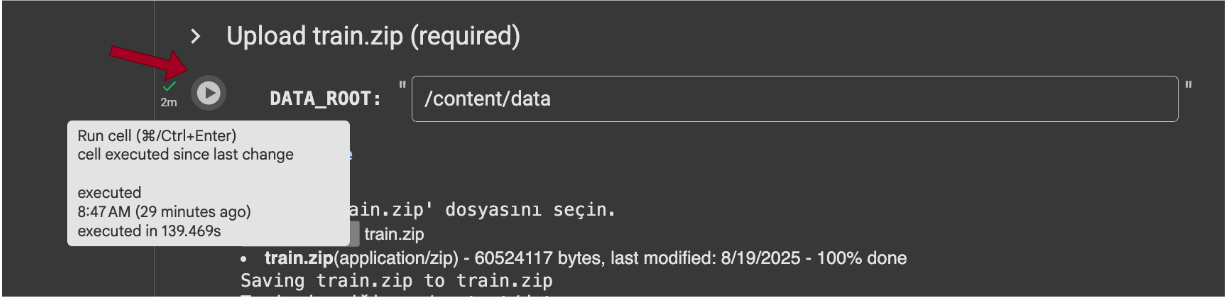


The block diagram of the notebook is illustrated below. It summarizes the workflow step by step, highlighting which steps require user input, which apply defaults, and which only need to be executed without modification.

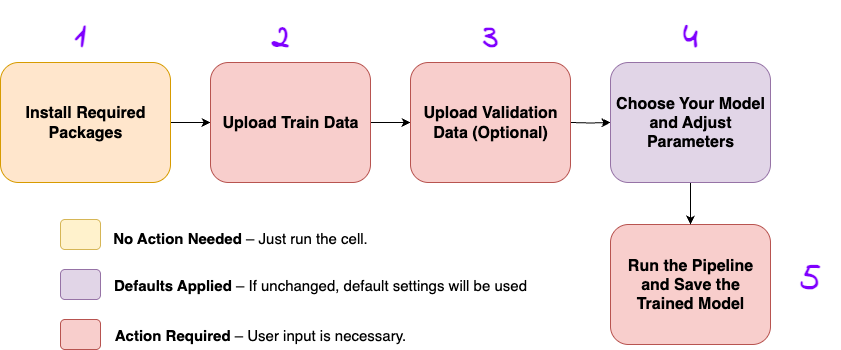

In [ ]:
# @title 1 - Install Required Packages

# Install external packages (only needed in Colab/Notebook)
!pip install split-folders

# --- Standard Library ---
import os
import io
import shutil
import itertools
import pathlib
from glob import glob
from pathlib import Path
import contextlib
import warnings
import json

# --- Scientific stack ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Widgets / Display ---
import ipywidgets as widgets
from IPython.display import display, Markdown

# --- TensorFlow / Keras ---
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Backbones
from tensorflow.keras.applications import (
    EfficientNetB0, MobileNetV2, ResNet50, InceptionV3
)

# Preprocessing functions
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_pre
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_pre
from tensorflow.keras.applications.resnet50 import preprocess_input as res_pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_pre

# --- Data split helper ---
import splitfolders

# --- Scikit-learn ---
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


def _zip_dir(src_dir, zip_path):
    # Remove existing zip if present
    if os.path.exists(zip_path):
        os.remove(zip_path)
    base, _ = os.path.splitext(zip_path)
    # shutil.make_archive wants base name without .zip + format
    shutil.make_archive(base, 'zip', root_dir=src_dir)
    return zip_path

def _safe_download(path):
    if os.path.exists(path):
        files.download(path)
        print(f"Downloading: {os.path.basename(path)}")
    else:
        print(f"Not found: {path}")
def on_click_keras(b):
    with out:
        _safe_download(keras_path)
def on_click_h5(b):
    with out:
        _safe_download(h5_path)

def on_click_tflite(b):
    with out:
        _safe_download(tflite_path)

def on_click_savedmodel(b):
    with out:
        if os.path.isdir(sm_dir):
            print("Zipping SavedModel directory...")
            _zip_dir(sm_dir, savedmodel_zip)
            _safe_download(savedmodel_zip)
        else:
            print(f"SavedModel directory not found: {sm_dir}")

def on_click_all(b):
    with out:
        if os.path.isdir(OUTPUT_DIR):
            print("Zipping all outputs...")
            _zip_dir(OUTPUT_DIR, all_outputs_zip)
            _safe_download(all_outputs_zip)
        else:
            print(f"Output folder not found: {OUTPUT_DIR}")

def _on_click(b):
    files.download("class_names.txt")


Prepare Your Dataset


Prepare Your Dataset  
   Organize your insect images so each species has its own folder:

```
train/
├── butterfly/
│   ├── img1.jpg
│   ├── img2.jpg
│   └── ...
└── beetle/
    ├── img1.jpg
    ├── img2.jpg
    └── ...
```

Create a train.zip file to upload.




In [ ]:
# @title 2-Upload train data (train.zip (required))
from google.colab import files
import zipfile, os

print("👉 Please upload your train.zip file")
uploaded_train = files.upload()

train_zip = list(uploaded_train.keys())[0]
train_dir = "/content/data/"
os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(train_zip, 'r') as z:
    z.extractall(train_dir)
print(f"✅ Extracted {train_zip} to {train_dir}")



👉 Please upload your train.zip file


Saving train.zip to train (1).zip
✅ Extracted train (1).zip to /content/data/


In [ ]:
# @title 3-Upload Validation Data (val.zip (optional))
print("\n👉 (Optional) If you have a validation.zip, upload it now. Otherwise, just skip by pressing cancel.")
uploaded_val = files.upload()

if uploaded_val:
    val_zip = list(uploaded_val.keys())[0]
    val_dir = "/content/data/"
    os.makedirs(val_dir, exist_ok=True)

    with zipfile.ZipFile(val_zip, 'r') as z:
        z.extractall(val_dir)
    print(f"✅ Extracted {val_zip} to {val_dir}")
else:
    print("⚠️ No validation.zip uploaded. Proceeding with train data only.")



👉 (Optional) If you have a validation.zip, upload it now. Otherwise, just skip by pressing cancel.


⚠️ No validation.zip uploaded. Proceeding with train data only.


<h1>Choose Your Model and Adjust Parameters</h1>

These settings appear **below the cell as form fields**. You can change them without editing the code directly.

<h2>General Settings</h2>

- **DATA_DIR** – The folder where your dataset is stored. In Colab, you usually upload your images into this path.  
- **USE_LABELS_CSV** – If your dataset comes with a separate CSV file containing labels, set this to `True`. Otherwise, leave it as `False`.  
- **LABELS_CSV_PATH** – The file path to your labels CSV (only needed if the option above is `True`).  
- **BACKBONE** – The model architecture to use for training. Options: *EfficientNetB0*, *MobileNetV2*, *ResNet50*, *InceptionV3*. (Think of this as choosing a “brain” for your AI model.)  


<h2> Training Parameters</h2>

- **IMG_SIZE** – The size to which all images will be resized (e.g., `224 × 224` pixels).  
- **BATCH_SIZE** – Number of images processed together in one training step.  
- **EPOCHS** – How many times the model will go through the full dataset during training.  
- **VAL_SPLIT** – The fraction of the dataset used for validation (e.g., `0.2` = 20%).  
- **AUTO_SPLIT_IF_NO_VAL** – If `True`, Colab will automatically create a validation split if none is provided.  
- **AUGMENTATION** – If `True`, applies small changes (rotation, flipping, etc.) to images to improve robustness.  
- **LEARNING_RATE** – How fast the model learns. A smaller number = slower but more stable learning.  
- **OUTPUT_DIR** – The folder where all results (trained model files, logs, etc.) will be saved.  


In [ ]:
# @title 4-Choose your model and adjust parameters (Re-run this cell and all cells below if you change the settings)
DATA_DIR = '/content/data' #@param {type:"string"}
USE_LABELS_CSV = False #@param {type:"boolean"}
LABELS_CSV_PATH = '/content/data/my_dataset/labels.csv' #@param {type:"string"}

BACKBONE = 'EfficientNetB0' #@param ["EfficientNetB0", "MobileNetV2", "ResNet50", "InceptionV3"]

# Train parameters
IMG_SIZE = 224 #@param {type:"integer"}
BATCH_SIZE = 32 #@param {type:"integer"}
EPOCHS = 5 #@param {type:"integer"}
VAL_SPLIT = 0.2 #@param {type:"number"}
AUTO_SPLIT_IF_NO_VAL = True #@param {type:"boolean"}
AUGMENTATION = False #@param {type:"boolean"}
LEARNING_RATE = 0.0005 #@param {type:"number"}

OUTPUT_DIR = '/content/output' #@param {type:"string"}
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('Settings are loaded.')

Settings are loaded.


### Pipeline

Button(button_style='success', description='Run Pipeline', layout=Layout(height='42px', width='220px'), style=…

BACKBONE=EfficientNetB0, IMG_SIZE=224, BATCH_SIZE=32, EPOCHS=5, LR=0.0005, AUGMENTATION=False, VAL_SPLIT=0.2
DATA_DIR=/content/data, USE_LABELS_CSV=False
=== PARAM SNAPSHOT ===
{'DATA_DIR': '/content/data', 'USE_LABELS_CSV': False, 'LABELS_CSV_PATH': '/content/data/my_dataset/labels.csv', 'BACKBONE': 'EfficientNetB0', 'IMG_SIZE': 224, 'BATCH_SIZE': 32, 'EPOCHS': 5, 'VAL_SPLIT': 0.2, 'AUTO_SPLIT_IF_NO_VAL': True, 'AUGMENTATION': False, 'LEARNING_RATE': 0.0005, 'OUTPUT_DIR': '/content/output'}


Copying files: 64 files [00:00, 1775.34 files/s]

train_dir: /content/data_split/train
val_dir  : /content/data_split/val
Found 50 files belonging to 2 classes.
Found 14 files belonging to 2 classes.
class_names.txt created, content: ['jerry', 'tom']
Classes: ['jerry', 'tom']


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3719 - loss: 0.9525  
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/output/EfficientNetB0_best.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 10s/step - accuracy: 0.3812 - loss: 0.9418 - val_accuracy: 0.5000 - val_loss: 0.7721 - learning_rate: 5.0000e-04
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3875 - loss: 0.8282  
Epoch 2: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3917 - loss: 0.8261 - val_accuracy: 0.5000 - val_loss: 0.7454 - learning_rate: 5.0000e-04
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4287 - loss: 0.8370
Epoch 3: val_accuracy did not improve from 0.50000
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4258 - loss: 0.8370 - val_accuracy: 0.5000 - val_loss: 0.7261 - learning_rate: 5.0000e-04
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5100 - loss: 0.7676
Epoch 4: val_accuracy did not improve f

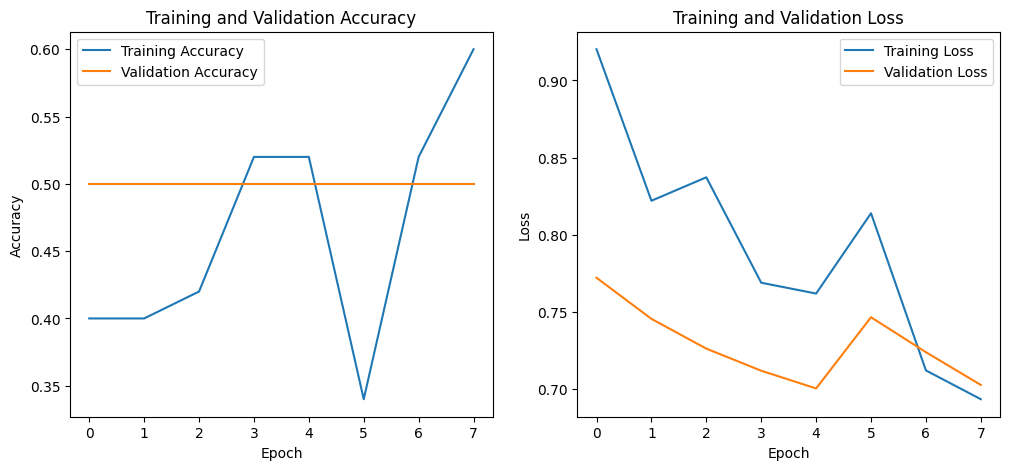

              precision    recall  f1-score   support

       jerry       0.50      0.71      0.59         7
         tom       0.50      0.29      0.36         7

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.48        14
weighted avg       0.50      0.50      0.48        14



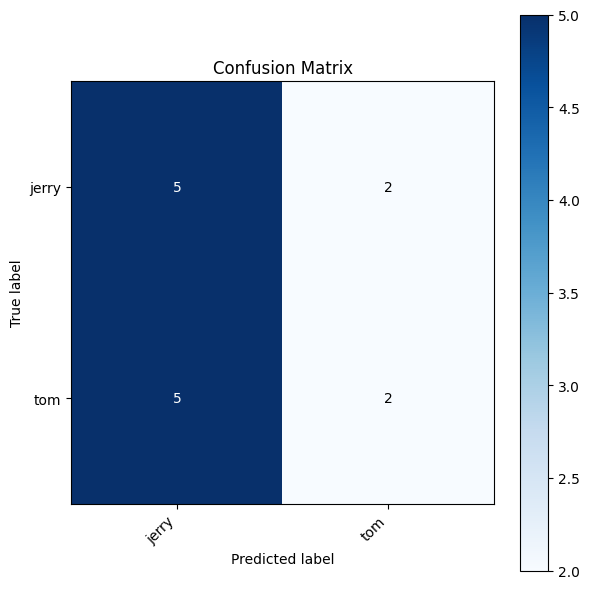

Output Folder: /content/output


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title 5-Run the Pipeline and Save the Trained Model

def get_params_snapshot():
    import json
    keys = [
        "DATA_DIR", "USE_LABELS_CSV", "LABELS_CSV_PATH",
        "BACKBONE", "BACKBONE_TORCH",
        "IMG_SIZE", "BATCH_SIZE", "EPOCHS",
        "VAL_SPLIT", "AUTO_SPLIT_IF_NO_VAL", "AUGMENTATION",
        "LEARNING_RATE", "OUTPUT_DIR",
        "device"
    ]
    snap = {}
    for k in keys:
        if k in globals():
            v = globals()[k]
            try:
                json.dumps(v)  # serializable?
                snap[k] = v
            except TypeError:
                snap[k] = str(v)
    return snap


def run_training():

    try:
        import splitfolders
    except Exception:
        # split-folders yoksa basit bir uyarı ver
        print("Warning: 'splitfolders' not installed. AUTO_SPLIT_IF_NO_VAL=True ise pip ile kurun: pip install split-folders")

    try:
        import ipywidgets as widgets
        from google.colab import files
    except Exception:
        widgets = None
        files = None
        print("Note: ipywidgets/Colab download not available in this environment.")

    # ---- Globals we rely on / modify ----
    global DATA_DIR, OUTPUT_DIR, BACKBONE, IMG_SIZE, BATCH_SIZE, EPOCHS
    global VAL_SPLIT, AUTO_SPLIT_IF_NO_VAL, AUGMENTATION, LEARNING_RATE
    global USE_LABELS_CSV, LABELS_CSV_PATH

    # ---- Silence TF/absl logs ----
    from absl import logging as absl_logging
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.get_logger().setLevel('ERROR')
    absl_logging.set_verbosity(absl_logging.ERROR)
    warnings.filterwarnings("ignore")

    # ---- Defensive defaults ----
    OUTPUT_DIR = os.path.abspath(globals().get("OUTPUT_DIR", "./output"))
    pathlib.Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

    print("=== PARAM SNAPSHOT ===")
    print(get_params_snapshot())

    # ---------- DATASET PREP ----------
    train_dir = os.path.join(DATA_DIR, 'train')
    val_dir = os.path.join(DATA_DIR, 'val')

    if os.path.isdir(train_dir) and (not os.path.isdir(val_dir)) and AUTO_SPLIT_IF_NO_VAL and not USE_LABELS_CSV:
        tmp_out = '/content/data_split'
        if os.path.exists(tmp_out):
            shutil.rmtree(tmp_out)
        try:
            splitfolders.ratio(train_dir, output=tmp_out, seed=42, ratio=(1-VAL_SPLIT, VAL_SPLIT))
            DATA_DIR = tmp_out
            train_dir = os.path.join(DATA_DIR, 'train')
            val_dir = os.path.join(DATA_DIR, 'val')
        except Exception as e:
            print("AUTO SPLIT failed:", e)

    print('train_dir:', train_dir)
    print('val_dir  :', val_dir)

    IMG_SIZE = int(IMG_SIZE)
    img_size = (IMG_SIZE, IMG_SIZE)

    if not USE_LABELS_CSV:
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir, image_size=img_size, batch_size=BATCH_SIZE, shuffle=True)
        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            val_dir, image_size=img_size, batch_size=BATCH_SIZE, shuffle=False)
        class_names = train_ds.class_names

        # class_names.txt (çalışma kökünde)
        with open("class_names.txt", "w", encoding="utf-8") as f:
            for cls in class_names:
                f.write(cls + "\n")
        print("class_names.txt created, content:", class_names)
    else:
        df = pd.read_csv(LABELS_CSV_PATH)
        class_names = sorted(df['label'].unique().tolist())
        class_to_idx = {c: i for i, c in enumerate(class_names)}

        paths = df['filepath'].tolist()
        labels = df['label'].map(class_to_idx).values

        def load_image(path, label):
            raw = tf.io.read_file(os.path.join(DATA_DIR, path))
            img = tf.io.decode_image(raw, channels=3)
            img = tf.image.resize(img, img_size)
            img.set_shape((IMG_SIZE, IMG_SIZE, 3))
            return img, label

        full_ds = tf.data.Dataset.from_tensor_slices((paths, labels)).map(
            load_image, num_parallel_calls=tf.data.AUTOTUNE)
        n_total = len(paths)
        n_val = int(n_total * VAL_SPLIT)
        val_ds = full_ds.take(n_val).batch(BATCH_SIZE)
        train_ds = full_ds.skip(n_val).shuffle(1000).batch(BATCH_SIZE)

    train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

    print('Classes:', class_names)
    NUM_CLASSES = len(class_names)

    # ---------- MODEL BUILD ----------
    # Bu map'lerin ve EfficientNetB0/MobileNetV2/ResNet50/InceptionV3 sınıflarının
    # önceki hücrede import edildiğini varsayıyoruz.
    preprocess_map = {
        'EfficientNetB0': eff_pre,
        'MobileNetV2':    mob_pre,
        'ResNet50':       res_pre,
        'InceptionV3':    inc_pre
    }
    base_map = {
        'EfficientNetB0': EfficientNetB0,
        'MobileNetV2':    MobileNetV2,
        'ResNet50':       ResNet50,
        'InceptionV3':    InceptionV3
    }

    pre_fn = preprocess_map[BACKBONE]
    BaseClass = base_map[BACKBONE]

    if AUGMENTATION:
        aug = tf.keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
        ], name="aug")
    else:
        aug = layers.Lambda(lambda x: x, name="identity_aug")

    pre = tf.keras.layers.Lambda(pre_fn)

    base = BaseClass(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
    base.trainable = False
    inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = aug(inp)
    x = pre(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    ckpt_path = os.path.join(OUTPUT_DIR, f'{BACKBONE}_best.keras')
    callbacks = [
        ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]

    hist = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

    # Fine-tune
    base.trainable = True
    for layer in base.layers[:-20]:
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE/10),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    hist_ft = model.fit(train_ds, validation_data=val_ds, epochs=max(3, EPOCHS//3), callbacks=callbacks)

    print('Best model:', ckpt_path)
    print('The file `class_names.txt` has been generated.')
    print('Please download it after all cells have finished running, you will need this file later when testing your model with the Gradio interface.')

    # Combine history
    def combine_history(h1, h2):
        history = {}
        for key in h1.history.keys():
            history[key] = h1.history[key] + h2.history.get(key, [])
        return history

    history = combine_history(hist, hist_ft)

    # ---------- PLOTS ----------
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training and Validation Accuracy'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss'); plt.legend()
    plt.show()

    y_true, y_pred = [], []
    for imgs, labels in val_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy().tolist())
        y_pred.extend(np.argmax(preds, axis=1).tolist())

    cm = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=class_names))

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix'); plt.colorbar()
    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.show()

    # ---------- EXPORTS (ALL INSIDE) ----------
    def _silent(fn, *args, **kwargs):
        f_out, f_err = io.StringIO(), io.StringIO()
        with contextlib.redirect_stdout(f_out), contextlib.redirect_stderr(f_err):
            return fn(*args, **kwargs)

    # 1) .keras
    keras_path = os.path.join(OUTPUT_DIR, f"{BACKBONE}_final.keras")
    _silent(model.save, keras_path)

    # 2) .h5 (best-effort)
    h5_file_path = os.path.join(OUTPUT_DIR, f"{BACKBONE}_final.h5")
    try:
        _silent(model.save, h5_file_path)
    except Exception:
        h5_file_path = None

    # 3) SavedModel
    sm_dir = os.path.join(OUTPUT_DIR, f"{BACKBONE}_savedmodel")
    try:
        if hasattr(model, "export"):   # Keras 3
            _silent(model.export, sm_dir)
        else:
            _silent(tf.saved_model.save, model, sm_dir)
    except Exception:
        sm_dir = None

    # 4) TFLite
    tflite_path = None
    if sm_dir and os.path.isdir(sm_dir):
        try:
            converter = tf.lite.TFLiteConverter.from_saved_model(sm_dir)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            tflite_model = _silent(converter.convert)
            tflite_path = os.path.join(OUTPUT_DIR, f"{BACKBONE}.tflite")
            with open(tflite_path, "wb") as f:
                f.write(tflite_model)
        except Exception:
            tflite_path = None

    # 5) class_names.txt (OUTPUT_DIR içine de kopyala)
    class_txt = os.path.join(OUTPUT_DIR, "class_names.txt")
    try:
        if "class_names" in locals() and isinstance(class_names, (list, tuple)):
            with open(class_txt, "w", encoding="utf-8") as f:
                for c in class_names: f.write(str(c) + "\n")
        elif os.path.isdir(os.path.join(DATA_DIR, "train")):
            classes = sorted([
                d for d in os.listdir(os.path.join(DATA_DIR, "train"))
                if os.path.isdir(os.path.join(DATA_DIR, "train", d))
            ])
            if classes:
                with open(class_txt, "w", encoding="utf-8") as f:
                    for c in classes: f.write(str(c) + "\n")
    except Exception:
        pass

    print("Output Folder:", OUTPUT_DIR)

    # ---------- DOWNLOAD UI (INSIDE) ----------
    if widgets is None or files is None:
        print("Download UI skipped (no ipywidgets/Colab).")
        return {
            "keras": keras_path,
            "h5": h5_file_path,
            "tflite": tflite_path,
            "savedmodel_dir": sm_dir,
            "class_names": class_txt,
            "output_dir": OUTPUT_DIR
        }

    # Helper: zip a directory
    import zipfile
    def zip_dir(src_dir, dst_zip):
        if os.path.exists(dst_zip):
            os.remove(dst_zip)
        with zipfile.ZipFile(dst_zip, 'w', zipfile.ZIP_DEFLATED) as z:
            for root, _, files_ in os.walk(src_dir):
                for f in files_:
                    full = os.path.join(root, f)
                    rel = os.path.relpath(full, src_dir)
                    z.write(full, rel)

    savedmodel_zip = os.path.join(OUTPUT_DIR, f"{BACKBONE}_savedmodel.zip")
    all_outputs_zip = os.path.join(OUTPUT_DIR, f"{BACKBONE}_all_outputs.zip")

    # Prepare ALL zip
    def build_all_zip():
        if os.path.exists(all_outputs_zip):
            os.remove(all_outputs_zip)
        with zipfile.ZipFile(all_outputs_zip, 'w', zipfile.ZIP_DEFLATED) as z:
            for p in [keras_path, h5_file_path, tflite_path, class_txt]:
                if p and os.path.exists(p):
                    z.write(p, os.path.basename(p))
            if sm_dir and os.path.isdir(sm_dir):
                for root, _, files_ in os.walk(sm_dir):
                    for f in files_:
                        full = os.path.join(root, f)
                        rel = os.path.relpath(full, os.path.dirname(sm_dir))
                        z.write(full, rel)

    # Buttons
    btn_keras = widgets.Button(description="Download .keras", button_style='primary',
                               layout=widgets.Layout(width="220px", height="48px"))
    btn_h5 = widgets.Button(description="Download .h5", button_style='primary',
                            layout=widgets.Layout(width="220px", height="48px"))
    btn_tflite = widgets.Button(description="Download .tflite", button_style='primary',
                                layout=widgets.Layout(width="220px", height="48px"))
    btn_savedmodel = widgets.Button(description="Download SavedModel (.zip)", button_style='info',
                                    layout=widgets.Layout(width="260px", height="48px"))
    btn_all = widgets.Button(description="Download ALL outputs (.zip)", button_style='success',
                             layout=widgets.Layout(width="260px", height="48px"))
    btn_cls = widgets.Button(description="Download class_names.txt", button_style="success",
                             icon="download", layout=widgets.Layout(width="260px", height="48px"))

    out = widgets.Output()

    # Callbacks (default-arg trick to capture current paths)
    def on_click_download(path):
        if path and os.path.exists(path):
            files.download(path)
        else:
            with out:
                print("File not found:", path)

    def on_click_keras(_):
        on_click_download(keras_path)

    def on_click_h5(_):
        if h5_file_path and os.path.exists(h5_file_path):
            on_click_download(h5_file_path)
        else:
            with out:
                print(".h5 not available in this Keras version.")

    def on_click_tflite(_):
        if tflite_path and os.path.exists(tflite_path):
            on_click_download(tflite_path)
        else:
            with out:
                print(".tflite not available (SavedModel/TFLite convert failed).")

    def on_click_savedmodel(_):
        if sm_dir and os.path.isdir(sm_dir):
            zip_dir(sm_dir, savedmodel_zip)
            on_click_download(savedmodel_zip)
        else:
            with out:
                print("SavedModel directory not available.")

    def on_click_all(_):
        build_all_zip()
        on_click_download(all_outputs_zip)

    def on_click_class_names(_):
        if os.path.exists(class_txt):
            on_click_download(class_txt)
        else:
            with out:
                print("class_names.txt not found.")

    # Wire-up
    btn_keras.on_click(on_click_keras)
    btn_h5.on_click(on_click_h5)
    btn_tflite.on_click(on_click_tflite)
    btn_savedmodel.on_click(on_click_savedmodel)
    btn_all.on_click(on_click_all)
    btn_cls.on_click(on_click_class_names)

    box = widgets.VBox([
        widgets.HTML(
            "Download trained model files"
            "Click a button below to download your trained model files. "
            "If you don’t see the files, please complete the training step first."
        ),
        widgets.HBox([btn_keras, btn_tflite, btn_h5]),
        widgets.HBox([btn_savedmodel, btn_all, btn_cls]),
        out
    ])
    display(box)

    # Return paths as well (useful for programmatic callers)
    return {
        "keras": keras_path,
        "h5": h5_file_path,
        "tflite": tflite_path,
        "savedmodel_dir": sm_dir,
        "class_names": class_txt,
        "output_dir": OUTPUT_DIR
    }



STATE = globals().setdefault("_ONEBTN_STATE", {"running": False, "confirmed": False})

run_btn = widgets.Button(
    description="Run Pipeline",
    button_style="success",
    layout=widgets.Layout(width="220px", height="42px")
)

def _safe_call(*names):
    """Verilen isimlerden mevcut ve çağrılabilir olan ilk fonksiyonu çağır."""
    for name in names:
        fn = globals().get(name)
        if callable(fn):
            return fn()


def _confirm_params_once():
    """Parametre onayı: varsa PARAMS_LOCKED=True yapar."""
    if not STATE["confirmed"]:
        globals()["PARAMS_LOCKED"] = True
        STATE["confirmed"] = True
        print("Parameters confirmed.")

def on_run(_):
    if STATE["running"]:
        print("⏳ Already running…")
        return

    STATE["running"] = True
    run_btn.description = "⏳ Running..."
    run_btn.disabled = True

    _confirm_params_once()

    try:
        # 0) Parametre özetini al
        snap_local = get_params_snapshot()

        # Kısa özet
        print(
            f"BACKBONE={snap_local.get('BACKBONE')}, IMG_SIZE={snap_local.get('IMG_SIZE')}, "
            f"BATCH_SIZE={snap_local.get('BATCH_SIZE')}, EPOCHS={snap_local.get('EPOCHS')}, "
            f"LR={snap_local.get('LEARNING_RATE')}, AUGMENTATION={snap_local.get('AUGMENTATION')}, "
            f"VAL_SPLIT={snap_local.get('VAL_SPLIT')}"
        )
        print(f"DATA_DIR={snap_local.get('DATA_DIR')}, USE_LABELS_CSV={snap_local.get('USE_LABELS_CSV')}")

        # 1) Training
        _safe_call("run_training", "train", "start_training")

    finally:
        run_btn.description = "✅ Done"
        STATE["running"] = False
        run_btn.disabled = False


run_btn.on_click(on_run)

display(Markdown("### Pipeline"))
display(run_btn)

